# hw2: Решающие деревья

*Спасибо великому курсу великого Евгения Соколова*

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплементацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

Все данные, на которых будут обучаться модели, вы можете найти на диске.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw2-trees.ipynb``` и модуль с реализованными функциями и классами ```hw2code.py``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце <<hw2>> в строке со своей фамилией о том, что вы выполнили работу с указанием ника на Kaggle. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [3]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0)
]

In [4]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

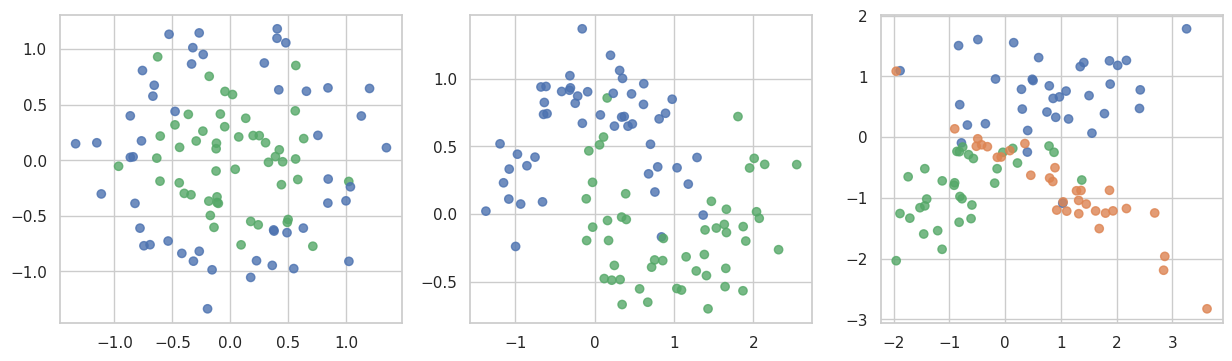

In [5]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__Задание 1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [6]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

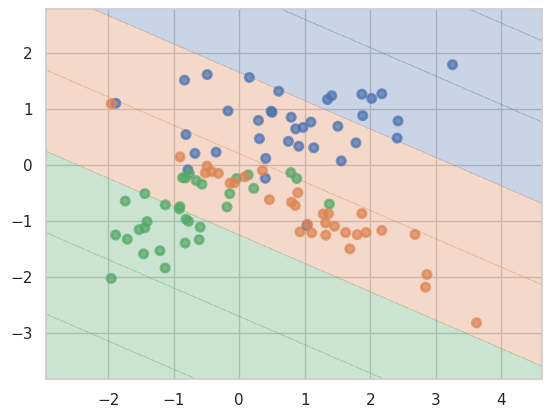

In [7]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

Dataset 1: Train accuracy = 1.0000, Test accuracy = 0.7333, Diff = 0.2667
Dataset 2: Train accuracy = 1.0000, Test accuracy = 0.8667, Diff = 0.1333
Dataset 3: Train accuracy = 1.0000, Test accuracy = 0.8333, Diff = 0.1667


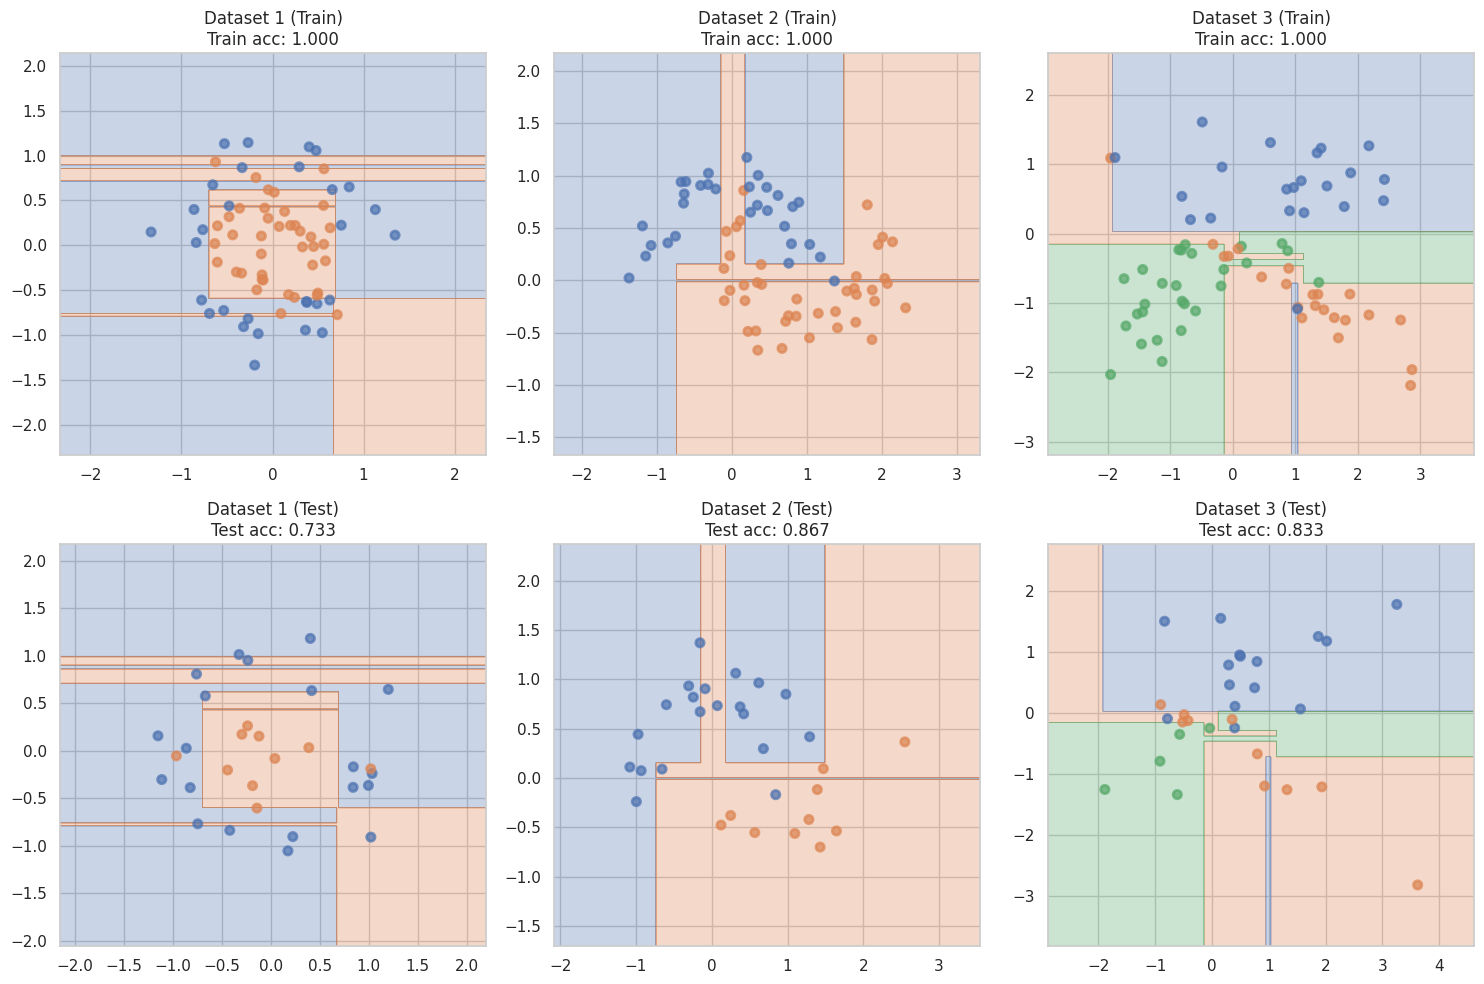

In [8]:
from sklearn.metrics import accuracy_score

plt.figure(figsize=(15, 10))

for i, (X, y) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)
    
    train_acc = accuracy_score(y_train, clf.predict(X_train))
    test_acc = accuracy_score(y_test, clf.predict(X_test))
    
    plt.subplot(2, 3, i + 1)
    plot_surface(clf, X_train, y_train)
    plt.title(f'Dataset {i+1} (Train)\nTrain acc: {train_acc:.3f}')
    
    plt.subplot(2, 3, i + 4)
    plot_surface(clf, X_test, y_test)
    plt.title(f'Dataset {i+1} (Test)\nTest acc: {test_acc:.3f}')
    
    print(f'Dataset {i+1}: Train accuracy = {train_acc:.4f}, Test accuracy = {test_acc:.4f}, Diff = {train_acc - test_acc:.4f}')

plt.tight_layout()

__Ответ:__
Деревья сильно переобучились, на тренировочных данных идеальная точность, а на тестовых довольно сильное падение.

__Задание 2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?


=== Dataset 1 ===
max_depth=2: Train=0.8286, Test=0.6333, Diff=0.1952
max_depth=5: Train=0.9714, Test=0.7667, Diff=0.2048
min_samples_leaf=10: Train=0.8143, Test=0.7667, Diff=0.0476
min_samples_leaf=20: Train=0.6857, Test=0.7333, Diff=-0.0476


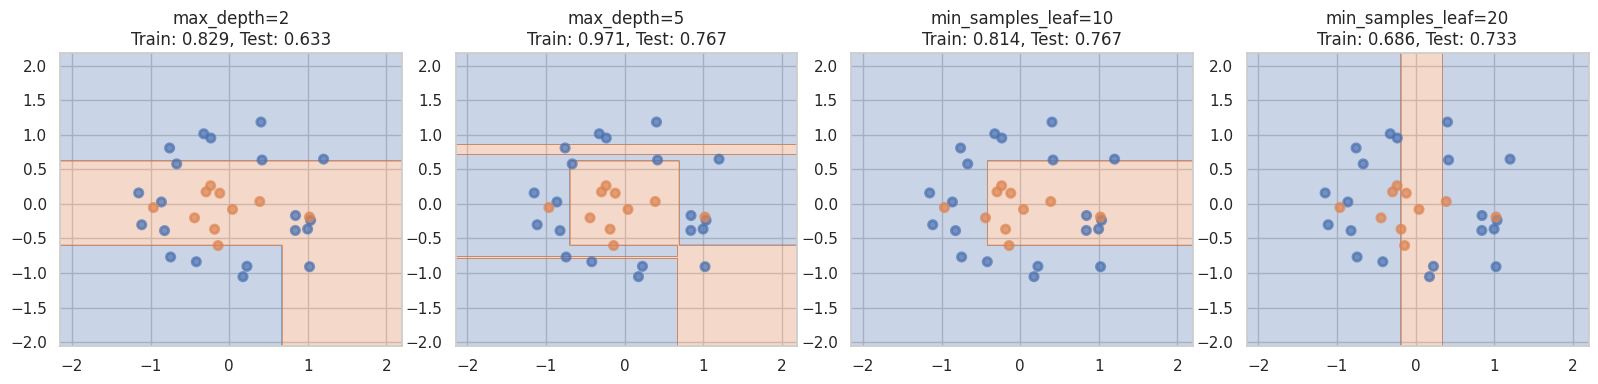


=== Dataset 2 ===
max_depth=2: Train=0.9143, Test=0.9333, Diff=-0.0190
max_depth=5: Train=1.0000, Test=0.8667, Diff=0.1333
min_samples_leaf=10: Train=0.8714, Test=0.7667, Diff=0.1048
min_samples_leaf=20: Train=0.8429, Test=0.8000, Diff=0.0429


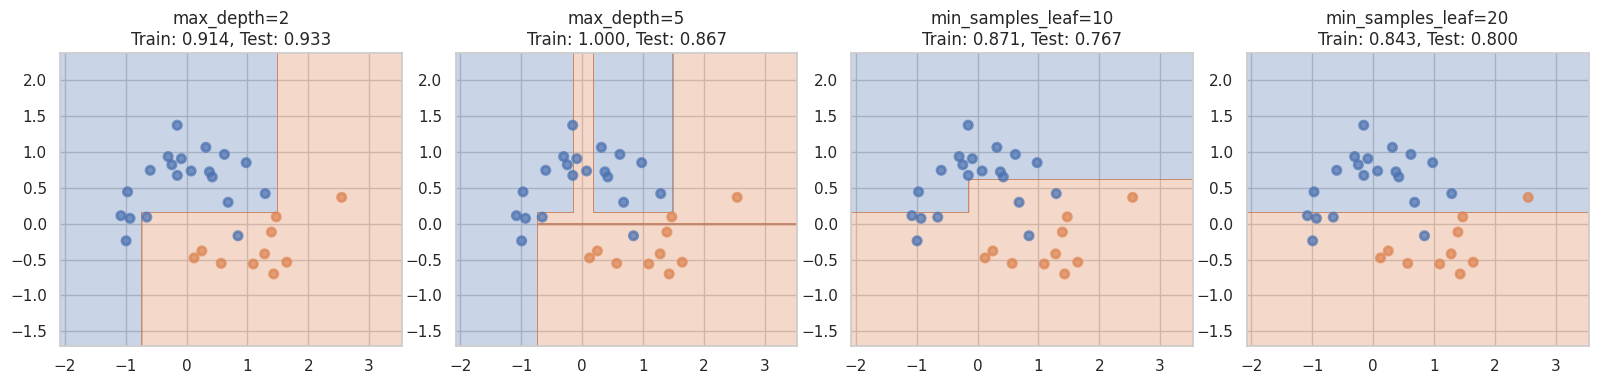


=== Dataset 3 ===
max_depth=2: Train=0.9000, Test=0.7667, Diff=0.1333
max_depth=5: Train=0.9714, Test=0.8000, Diff=0.1714
min_samples_leaf=10: Train=0.8857, Test=0.7667, Diff=0.1190
min_samples_leaf=20: Train=0.8857, Test=0.7667, Diff=0.1190


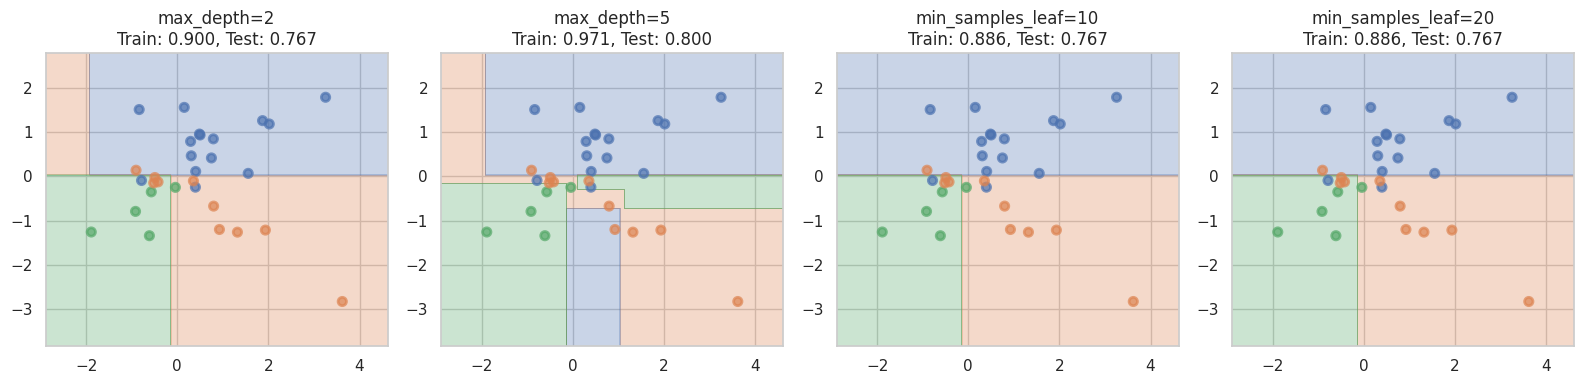

In [9]:
params_list = [
    {'max_depth': 2, 'name': 'max_depth=2'},
    {'max_depth': 5, 'name': 'max_depth=5'},
    {'min_samples_leaf': 10, 'name': 'min_samples_leaf=10'},
    {'min_samples_leaf': 20, 'name': 'min_samples_leaf=20'}
]

for dataset_idx, (X, y) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    print(f'\n=== Dataset {dataset_idx + 1} ===')
    
    plt.figure(figsize=(16, 4))
    
    for i, params in enumerate(params_list):
        param_dict = {k: v for k, v in params.items() if k != 'name'}
        clf = DecisionTreeClassifier(random_state=42, **param_dict)
        clf.fit(X_train, y_train)
        
        train_acc = accuracy_score(y_train, clf.predict(X_train))
        test_acc = accuracy_score(y_test, clf.predict(X_test))
        
        plt.subplot(1, 4, i + 1)
        plot_surface(clf, X_test, y_test)
        plt.title(f"{params['name']}\nTrain: {train_acc:.3f}, Test: {test_acc:.3f}")
        
        print(f"{params['name']}: Train={train_acc:.4f}, Test={test_acc:.4f}, Diff={train_acc-test_acc:.4f}")
    
    plt.tight_layout()
    plt.show()

__Ответ:__
Регуляризация по-разному влияет на разные датасеты из-за их сложности. Второй датасет с простой границей идеально работает с max_depth=2, в то время как первый со сложной круговой границей требует более тонкой регуляризации через min_samples_leaf. Третий датасет стабильно переобучается, показывая что его структура плохо соответствует ось-параллельным разделениям деревьев. Разделяющие поверхности упрощаются - убираются зубчатые границы, но эффективность зависит от соответствия сложности модели истинной структуре данных.

# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__Задание 3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw2code.py

__Задание 4. (0.5 балла)__

Загрузите таблицу students.csv (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

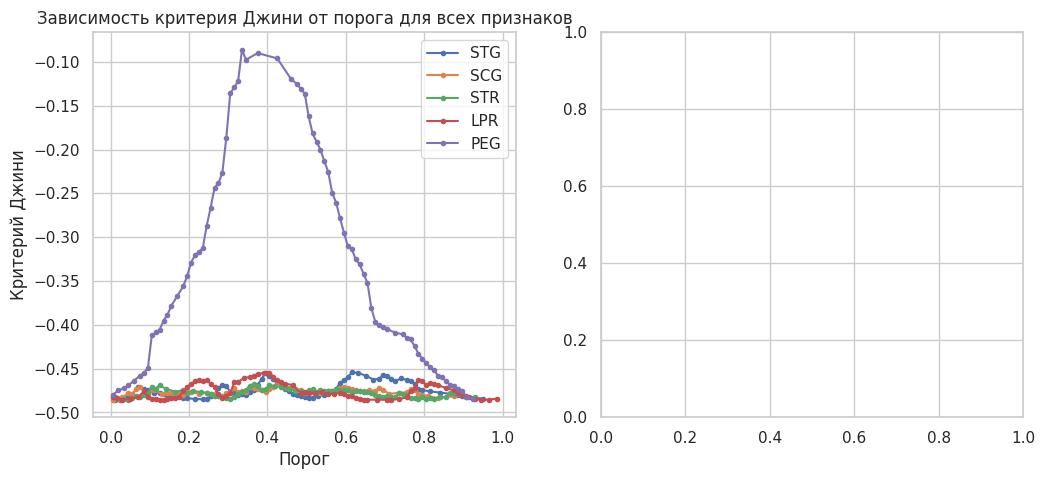

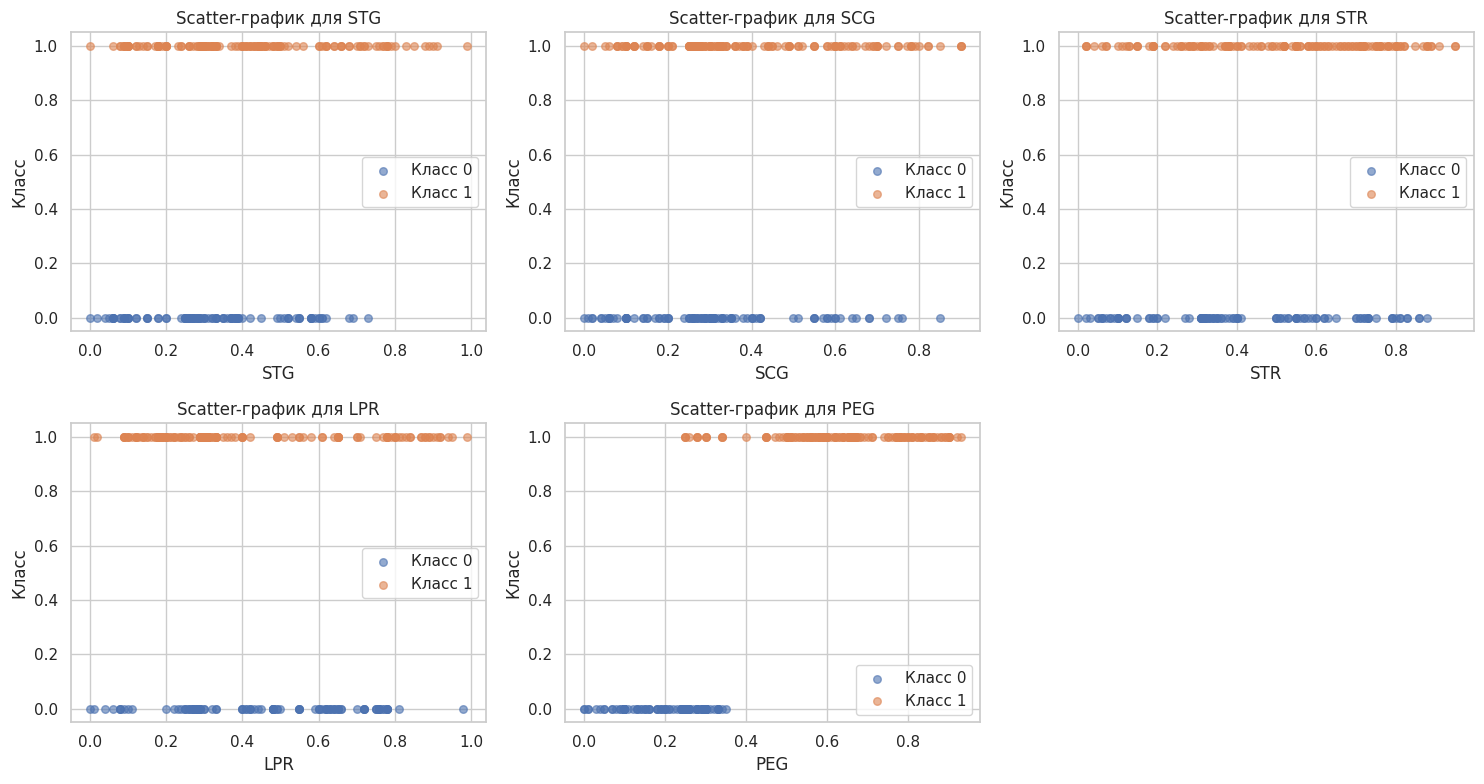

In [10]:
import pandas as pd
from hw2code import find_best_split

data = pd.read_csv('datasets/students.csv')
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
feature_names = data.columns[:-1]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for i in range(X.shape[1]):
    thresholds, ginis, threshold_best, gini_best = find_best_split(X[:, i], y)
    plt.plot(thresholds, ginis, label=feature_names[i], marker='o', markersize=3)

plt.xlabel('Порог')
plt.ylabel('Критерий Джини')
plt.title('Зависимость критерия Джини от порога для всех признаков')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i in range(X.shape[1]):
    axes[i].scatter(X[y == 0, i], y[y == 0], alpha=0.6, label='Класс 0', s=30)
    axes[i].scatter(X[y == 1, i], y[y == 1], alpha=0.6, label='Класс 1', s=30)
    axes[i].set_xlabel(feature_names[i])
    axes[i].set_ylabel('Класс')
    axes[i].set_title(f'Scatter-график для {feature_names[i]}')
    axes[i].legend()
    axes[i].grid(True)

axes[5].remove()

plt.tight_layout()
plt.show()


__Задание 5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:**
Лучший признак для деления - PEG, поскольку его кривая критерия Джини значительно выделяется по масштабу и форме по сравнению с остальными. По графику видно, что для PEG значения критерия Джини значительно выше по модулю и демонстрируют выраженный пик, когда остальные признаки (STG, SCG, STR, LPR) дают почти плоские кривые около одного и того же уровня, без ярко выраженной зависимости от порога. Следовательно, оптимальным признаком для первого разбиения является PEG. Обычно PEG на scatter-парах выглядит как признак, по которому классы заметно разделены по вертикали или горизонтали, тогда как остальные признаки смешаны.

Для хорошего признака кривая Джини имеет выраженный пик или глубокий минимум и заметно меняется при изменении порога. Это указывает на существование чёткого оптимального разбиения.
Для плохих признаков кривая почти плоская и мало меняется по порогам, что показывает отсутствие полезной разделяющей информации.

__Задание 6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw2code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции. Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

__Задание 7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (лежит на гитхабе вместе с заданием), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [11]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from hw2code import DecisionTree

data = pd.read_csv('datasets/agaricus-lepiota.data', header=None)

X = data.iloc[:, 1:].values
y = data.iloc[:, 0].values

le = LabelEncoder()
y = le.fit_transform(y)

for i in range(X.shape[1]):
    le = LabelEncoder()
    X[:, i] = le.fit_transform(X[:, i])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

feature_types = ['categorical'] * X.shape[1]
tree = DecisionTree(feature_types)
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f'Accuracy: {acc:.4f}')
print(f'Количество правильных предсказаний: {np.sum(y_pred == y_test)} из {len(y_test)}')


Accuracy: 1.0000
Количество правильных предсказаний: 4062 из 4062


__Задание 8. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

__Задание 9. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце)
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце, датасет лежит на гитхабе вместе с заданием)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [12]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

datasets_dict = {}

data_mush = pd.read_csv('datasets/agaricus-lepiota.data', header=None)
X_mush = data_mush.iloc[:, 1:].values
y_mush = data_mush.iloc[:, 0].values
le = LabelEncoder()
y_mush = le.fit_transform(y_mush)

for i in range(X_mush.shape[1]):
    X_mush[:, i] = LabelEncoder().fit_transform(X_mush[:, i])
datasets_dict['mushrooms'] = (X_mush, y_mush)

data_ttt = pd.read_csv('datasets/tic-tac-toe-endgame.csv', header=None)
X_ttt = data_ttt.iloc[:, :-1].values
y_ttt = data_ttt.iloc[:, -1].values
y_ttt = LabelEncoder().fit_transform(y_ttt)
for i in range(X_ttt.shape[1]):
    X_ttt[:, i] = LabelEncoder().fit_transform(X_ttt[:, i])
datasets_dict['tic-tac-toe'] = (X_ttt, y_ttt)

def test_algorithms(X, y, dataset_name):
    results = {}
    
    tree_real = DecisionTree(['real'] * X.shape[1])
    scores = cross_val_score(tree_real, X, y, cv=5, scoring=make_scorer(accuracy_score))
    results['DT_real'] = scores.mean()
    
    tree_cat = DecisionTree(['categorical'] * X.shape[1])
    scores = cross_val_score(tree_cat, X, y, cv=5, scoring=make_scorer(accuracy_score))
    results['DT_categorical'] = scores.mean()
    
    from sklearn.preprocessing import OneHotEncoder
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    X_ohe = ohe.fit_transform(X)
    tree_ohe = DecisionTree(['real'] * X_ohe.shape[1])
    scores = cross_val_score(tree_ohe, X_ohe, y, cv=5, scoring=make_scorer(accuracy_score))
    results['DT_real_OHE'] = scores.mean()
    
    from sklearn.tree import DecisionTreeClassifier
    clf = DecisionTreeClassifier(random_state=42)
    scores = cross_val_score(clf, X, y, cv=5, scoring=make_scorer(accuracy_score))
    results['sklearn_DT'] = scores.mean()
    
    return results

results_df = pd.DataFrame()
for name, (X, y) in datasets_dict.items():
    print(f'Тестирование {name}...')
    results = test_algorithms(X, y, name)
    results_df = pd.concat([results_df, pd.DataFrame([results], index=[name])])

print('\nРезультаты:')
print(results_df)
    

Тестирование mushrooms...
Тестирование tic-tac-toe...

Результаты:
              DT_real  DT_categorical  DT_real_OHE  sklearn_DT
mushrooms    0.996799        0.988180     0.994335    0.961591
tic-tac-toe  0.410837        0.533666     0.523249    0.687407


__Задание 10. (1 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:**
Ранжирование алгоритмов различается, потому что структура признаков в наборах данных разная: в mushrooms почти все признаки бинарные и идеально отделяют классы, поэтому любая кодировка работает хорошо, тогда как в tic-tac-toe категориальная природа признаков делает вещественную интерпретацию некорректной и ухудшает качество. Случайность есть, так как CV и дерево используют рандомизацию, но её можно уменьшить фиксированием random_state; на общую картину это влияет мало.

Вставьте что угодно, описывающее ваши впечатления от этого задания:

In [ ]:
Сложновато